In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [24]:
dataset = pd.read_csv('dataset/GlobalTemperatures.csv')

In [25]:
dataset.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
dataset = dataset.drop(columns=["LandAverageTemperatureUncertainty", "LandMaxTemperatureUncertainty",
                      "LandMinTemperatureUncertainty", "LandAndOceanAverageTemperatureUncertainty"], axis=1)

In [27]:
dataset.head()

,dt,LandAverageTemperature,LandMaxTemperature,LandMinTemperature,LandAndOceanAverageTemperature
0,1750-01-01,3.034,NaN,NaN,NaN
1,1750-02-01,3.083,NaN,NaN,NaN
2,1750-03-01,5.626,NaN,NaN,NaN
3,1750-04-01,8.490,NaN,NaN,NaN
4,1750-05-01,11.573,NaN,NaN,NaN


In [28]:
dataset.isnull().sum()

dt                                   0
LandAverageTemperature              12
LandMaxTemperature                1200
LandMinTemperature                1200
LandAndOceanAverageTemperature    1200
dtype: int64

In [29]:
len(dataset)
toplot_heat = dataset.isnull()

<AxesSubplot:>

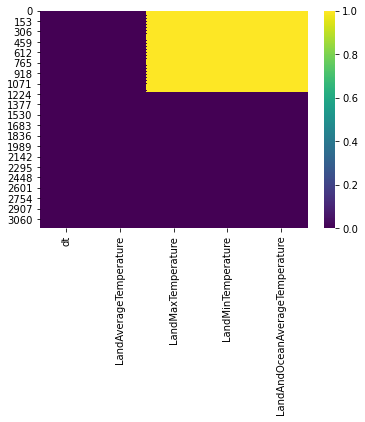

In [30]:
sns.heatmap(toplot_heat, cmap='viridis')

In [31]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 5 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   dt                              3192 non-null   object 
 1   LandAverageTemperature          3180 non-null   float64
 2   LandMaxTemperature              1992 non-null   float64
 3   LandMinTemperature              1992 non-null   float64
 4   LandAndOceanAverageTemperature  1992 non-null   float64
dtypes: float64(4), object(1)
memory usage: 124.8+ KB


In [32]:
def convert(x):
    x = (x*1.8) + 32
    return float(x)

In [33]:
dataset['LandAverageTemperature'] = dataset['LandAverageTemperature'].apply(convert)
dataset['LandMaxTemperature']= dataset['LandMaxTemperature'].apply(convert)
dataset['LandMinTemperature']= dataset['LandMinTemperature'].apply(convert)
dataset['LandAndOceanAverageTemperature'] = dataset['LandAndOceanAverageTemperature'].apply(convert)

In [34]:
# replacing the dt to month and year
dataset['dt'] = pd.to_datetime(dataset['dt'])
dataset['month']  = dataset['dt'].dt.month
dataset['year'] = dataset['dt'].dt.year
dataset.drop('dt', axis = 1, inplace= True)
dataset.set_index('year')
dataset = dataset.dropna()

In [37]:
dataset = dataset.set_index('year')

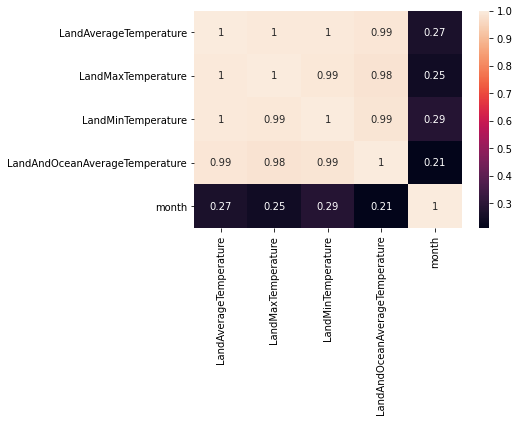

In [41]:
corrMatrix = dataset.corr()
sns.heatmap(corrMatrix, annot= True)
plt.show()

In [45]:
topredict = 'LandAndOceanAverageTemperature'
y = dataset[topredict]
x = pd.DataFrame(dataset, columns = ['LandAverageTemperature','LandMaxTemperature', 'LandMinTemperature'])
x.head()
y.head()

year
1850    55.0994
1850    56.4584
1850    57.2774
1850    58.4006
1850    59.9126
Name: LandAndOceanAverageTemperature, dtype: float64

In [47]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(x, y, test_size = 0.25, random_state=42)
print(xtrain.shape, xval.shape, ytrain.shape, yval.shape)

(1494, 3) (498, 3) (1494,) (498,)


In [51]:
from sklearn.metrics import mean_squared_error
y_pred = [ytrain.mean()]*len(ytrain)
print('BASELINE : MAE', round(mean_squared_error(ytrain, y_pred), 5))

BASELINE : MAE 5.29374


In [57]:
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn import pipeline
from sklearn.preprocessing import StandardScaler

forest = pipeline.make_pipeline(SelectKBest(k='all'),
                       StandardScaler(),
                       RandomForestRegressor(
                           n_estimators=100,
                           max_depth = 50,
                           random_state = 77,
                           n_jobs = -1
                       )
                      )
forest.fit(xtrain, ytrain)

Pipeline(steps=[('selectkbest', SelectKBest(k='all')),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=50, n_jobs=-1,
                                       random_state=77))])

In [62]:
y_pred = forest.predict(xval)

In [65]:
err = mean_squared_error(yval, y_pred)
print('new mean sq err is : ', err)

new mean sq err is :  0.1015448512690836


In [66]:
(1-err)*100

89.84551487309163

In [69]:
abs_err = abs(y_pred-yval)

In [70]:
mape = 100*(abs_err/yval)

In [71]:
accuracy = 100 -np.mean(mape)

In [72]:
accuracy

99.58661975226315

,LandAverageTemperature,LandMaxTemperature,LandMinTemperature,LandAndOceanAverageTemperature,month,year
0,3.034,NaN,NaN,NaN,1,1750
1,3.083,NaN,NaN,NaN,2,1750
2,5.626,NaN,NaN,NaN,3,1750
3,8.490,NaN,NaN,NaN,4,1750
4,11.573,NaN,NaN,NaN,5,1750


,LandAverageTemperature,LandMaxTemperature,LandMinTemperature,LandAndOceanAverageTemperature,month
year,,,,,
1750,3.034,NaN,NaN,NaN,1
1750,3.083,NaN,NaN,NaN,2
1750,5.626,NaN,NaN,NaN,3
1750,8.490,NaN,NaN,NaN,4
1750,11.573,NaN,NaN,NaN,5


LandAverageTemperature            0
LandMaxTemperature                0
LandMinTemperature                0
LandAndOceanAverageTemperature    0
month                             0
dtype: int64